In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flo-dataset/flo_data_20k.csv


# CLTV Prediction with BG-NBD & Gamma-Gamma Model 

## 1. Business Problem

A comprehensive roadmap has been developed for the sales and marketing endeavors of FLO company within the retail sector, aimed at enabling the company to formulate medium to long-term strategies. Additionally, leveraging analytical techniques such as BG-NBD and Gamma-Gamma models, predictive analysis has been conducted to estimate the potential Customer Lifetime Value (CLTV) that existing customers will contribute to the company in the foreseeable future.

## 2. About Dataset

 The data set consists of information obtained from the past shopping behavior of customers who made their last purchases as OmniChannel (both online and offline shoppers) in 2020 - 2021.

* **master_id:** Unique customer number
* **order_channel :** Which channel of the shopping platform is used (Android, iOS, Desktop, Mobile, Offline)
* **last_order_channel :** The channel where the last purchase was made
* **first_order_date :** Date of the customer's first purchase
* **last_order_date :** Date of the customer's last purchase
* **last_order_date_online :** The date of the last purchase made by the customer on the online platform
* **last_order_date_offline :** Date of the last purchase made by the customer on the offline platform
* **order_num_total_ever_online :** Total number of purchases made by the customer on the online platform
* **order_num_total_ever_offline :** Total number of purchases made by the customer offline
* **customer_value_total_ever_offline :** Total price paid by the customer for offline purchases
* **customer_value_total_ever_online :** Total price paid by the customer for online purchases
* **interested_in_categories_12 :** List of categories the customer has shopped in the last 12 months

## 3. Data Preparing & Understanding

In [2]:
import datetime as dt #data processing
import matplotlib.pyplot as plt #data visualization
!pip install lifetimes #data modelling
from lifetimes import BetaGeoFitter #BG-NBD model
from lifetimes import GammaGammaFitter #Gamma-Gamma model
from lifetimes.plotting import plot_period_transactions #data visualization
from sklearn.preprocessing import MinMaxScaler #feature scaling


df_ = pd.read_csv("/kaggle/input/flo-dataset/flo_data_20k.csv") #upload the dataset
df = df_.copy() # copy the dataset to protect original dataset
pd.set_option('display.max_columns', None) # display all columns 
pd.set_option('display.float_format', lambda x: '%.5f' % x) # display 5 digits after the dot for float numbers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.0 MB/s eta 0:00:00


In [3]:
df.head() #display first 5 columns

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00000,1.00000,139.99000,799.38000,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00000,2.00000,159.97000,1853.58000,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00000,2.00000,189.97000,395.35000,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00000,1.00000,39.99000,81.98000,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00000,1.00000,49.99000,159.99000,[AKTIFSPOR]


In [4]:
df.shape #display the shape of the dataset

(19945, 12)

In [5]:
df.columns # display the names of columns

Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date',
       'last_order_date', 'last_order_date_online', 'last_order_date_offline',
       'order_num_total_ever_online', 'order_num_total_ever_offline',
       'customer_value_total_ever_offline', 'customer_value_total_ever_online',
       'interested_in_categories_12'],
      dtype='object')

In [6]:
df.describe().T #descriptive statistics

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.00000,3.11085,4.22565,1.00000,1.00000,2.00000,4.00000,200.00000
order_num_total_ever_offline,19945.00000,1.91391,2.06288,1.00000,1.00000,1.00000,2.00000,109.00000
customer_value_total_ever_offline,19945.00000,253.92260,301.53285,10.00000,99.99000,179.98000,319.97000,18119.14000
customer_value_total_ever_online,19945.00000,497.32169,832.60189,12.99000,149.98000,286.46000,578.44000,45220.13000


In [7]:
df.isnull().sum() #number of the null values 

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [8]:
df.info() #info about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [9]:
# Defining the functions necessary for suppressing outliers

# find outlier thresholds:

def outlier_thresholds(dataframe, variable): 
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = round(quartile3 + 1.5 * interquantile_range)
    low_limit = round(quartile1 - 1.5 * interquantile_range)
    return low_limit, up_limit

# apply outlier thresholds:

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
# Let's suppress the outliers of the variables which need:

for col in ["order_num_total_ever_online",
            "order_num_total_ever_offline",
            "customer_value_total_ever_offline",
            "customer_value_total_ever_online"]:
    replace_with_thresholds(df, col)

df.describe().T # check descriptive statistics again

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.00000,3.09195,3.80954,1.00000,1.00000,2.00000,4.00000,48.00000
order_num_total_ever_offline,19945.00000,1.88619,1.43469,1.00000,1.00000,1.00000,2.00000,16.00000
customer_value_total_ever_offline,19945.00000,251.92132,251.02367,10.00000,99.99000,179.98000,319.97000,3020.00000
customer_value_total_ever_online,19945.00000,489.70568,632.60984,12.99000,149.98000,286.46000,578.44000,7800.00000


In [11]:
#creating new features to prepare CLTV prediction

# combine total numbers of online and offline orders
df["order_num_total_ever_online_offline"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

# combine total values of online and offline orders
df["customer_value_total_ever_online_offline"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]


In [12]:
# Converting date columns to datetime type

date_columns = ["first_order_date","last_order_date","last_order_date_online","last_order_date_offline"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

In [13]:
# Converting object data types to category types

categorical_columns = ['master_id', 'order_channel', 'last_order_channel','interested_in_categories_12']
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [14]:
df.info() #check the datatype again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   master_id                                 19945 non-null  category      
 1   order_channel                             19945 non-null  category      
 2   last_order_channel                        19945 non-null  category      
 3   first_order_date                          19945 non-null  datetime64[ns]
 4   last_order_date                           19945 non-null  datetime64[ns]
 5   last_order_date_online                    19945 non-null  datetime64[ns]
 6   last_order_date_offline                   19945 non-null  datetime64[ns]
 7   order_num_total_ever_online               19945 non-null  float64       
 8   order_num_total_ever_offline              19945 non-null  float64       
 9   customer_value_total_ever_of

## 4. Creating the CLTV Data Structure

In [15]:
# We defined 2 days after the last order date as the analysis date

today_date = df["last_order_date"].max() + dt.timedelta(days=2)

In [16]:
cltv = pd.DataFrame() #creating a new dataframe

In [17]:
# Creating CLTV features to the new dataframe 

cltv["customer_id"] = df["master_id"]

cltv["recency_cltv_weekly"] = (((df["last_order_date"] - df["first_order_date"]).dt.days) / 7)

cltv["T_weekly"] = ((today_date - df["first_order_date"]).dt.days) / 7

cltv["frequency"]  = df.loc[(df["order_num_total_ever_online_offline"] > 1), "order_num_total_ever_online_offline"]

cltv["monetary_cltv_avg"] = df["customer_value_total_ever_online_offline"] / df["order_num_total_ever_online_offline"]

cltv.head() #display first 5 columns

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00000,30.57143,5.00000,187.87400
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.85714,224.85714,21.00000,95.88333
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.28571,78.85714,5.00000,117.06400
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57143,20.85714,2.00000,60.98500
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14286,95.42857,2.00000,104.99000


## 5. Bulding BG/NBD & Gamma-Gamma Models 

In [18]:
# Building BG/NBD Model

bgf = BetaGeoFitter(penalizer_coef= 0.001) # defining BG/NBD model

bgf.fit(cltv["frequency"],             # fitting the model to the dataframe
        cltv["recency_cltv_weekly"],
        cltv["T_weekly"])


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [19]:
# Example of using the BG/NBD Model independently:

# Estimation of the expected number of transaction from customers within 3 months:

cltv["exp_sales_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4*3, cltv["frequency"], cltv["recency_cltv_weekly"], cltv["T_weekly"])

# Estimation of the expected number of transaction from customers within 6 months:

cltv["exp_sales_6_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4*6, cltv["frequency"], cltv["recency_cltv_weekly"], cltv["T_weekly"])

cltv.head() #display first 5 columns

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00000,30.57143,5.00000,187.87400,0.97393,1.94785
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.85714,224.85714,21.00000,95.88333,0.98316,1.96632
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.28571,78.85714,5.00000,117.06400,0.67059,1.34117
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57143,20.85714,2.00000,60.98500,0.70041,1.40082
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14286,95.42857,2.00000,104.99000,0.39604,0.79208


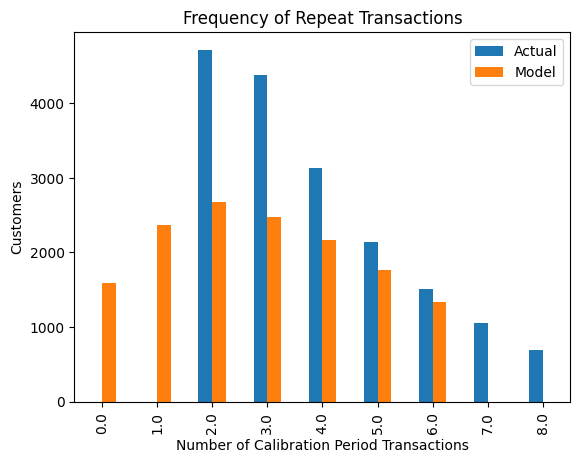

In [20]:
# Evaluation of BG/NBD Model prediction results

# data visualization

plot_period_transactions(bgf) 
plt.show() 

In [21]:
# Building Gamma-Gamma Model 

ggf = GammaGammaFitter(penalizer_coef= 0.01) # defining Gamma-Gamma model

ggf.fit(cltv["frequency"], cltv["monetary_cltv_avg"]) # fitting the model to the dataframe

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [22]:
# Example of using the Gamma Gamma Model independently:

# Estimation of the expected average profit from customers

cltv["exp_average_value"] = ggf.conditional_expected_average_profit(cltv["frequency"], cltv["monetary_cltv_avg"])

cltv.head() #display first 5 columns

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00000,30.57143,5.00000,187.87400,0.97393,1.94785,193.63268
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.85714,224.85714,21.00000,95.88333,0.98316,1.96632,96.66505
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.28571,78.85714,5.00000,117.06400,0.67059,1.34117,120.96762
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57143,20.85714,2.00000,60.98500,0.70041,1.40082,67.32015
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14286,95.42857,2.00000,104.99000,0.39604,0.79208,114.32511


## 6. Calculation of CLTV Prediction

In [23]:
# Calculation of the 6-month CLTV predictions:

cltv["cltv"] = ggf.customer_lifetime_value(bgf, cltv["frequency"],
                                           cltv["recency_cltv_weekly"],
                                           cltv["T_weekly"],
                                           cltv["monetary_cltv_avg"],
                                           time = 6,
                                           freq= "W",
                                           discount_rate = 0.01 )

cltv.head() #display first 5 columns

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00000,30.57143,5.00000,187.87400,0.97393,1.94785,193.63268,395.73323
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.85714,224.85714,21.00000,95.88333,0.98316,1.96632,96.66505,199.43069
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.28571,78.85714,5.00000,117.06400,0.67059,1.34117,120.96762,170.22418
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57143,20.85714,2.00000,60.98500,0.70041,1.40082,67.32015,98.94553
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14286,95.42857,2.00000,104.99000,0.39604,0.79208,114.32511,95.01166


In [24]:
# The top 20 customers by CLTV value

cltv.sort_values(by = "cltv", ascending = False).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.85714,7.85714,4.00000,1401.80000,1.09438,2.18877,1449.06047,3327.77704
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14286,13.14286,11.00000,758.08545,1.97011,3.94022,767.36060,3172.39439
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71429,101.00000,7.00000,1106.46714,0.72224,1.44448,1127.61153,1708.98206
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.28571,74.57143,16.00000,501.87375,1.56531,3.13062,506.16667,1662.61349
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71429,67.28571,52.00000,166.22462,4.65614,9.31228,166.71225,1628.88738
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.42857,34.42857,8.00000,601.22625,1.26546,2.53091,611.49262,1623.81268
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.28571,9.42857,2.00000,862.69000,0.79392,1.58785,923.67997,1538.85591
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71429,13.00000,17.00000,259.86529,2.78069,5.56138,262.07291,1529.22800
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57143,58.71429,31.00000,228.53000,3.08378,6.16756,229.60695,1485.81916
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.85714,15.57143,3.00000,743.58667,0.87156,1.74313,778.05037,1422.99967


In [25]:
# creating segmentations 

cltv["cltv_segment"] = pd.qcut(cltv["cltv"], 4, labels= ["D", "C", "B", "A"])

cltv.head() #display first 5 columns

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00000,30.57143,5.00000,187.87400,0.97393,1.94785,193.63268,395.73323,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.85714,224.85714,21.00000,95.88333,0.98316,1.96632,96.66505,199.43069,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.28571,78.85714,5.00000,117.06400,0.67059,1.34117,120.96762,170.22418,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57143,20.85714,2.00000,60.98500,0.70041,1.40082,67.32015,98.94553,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14286,95.42857,2.00000,104.99000,0.39604,0.79208,114.32511,95.01166,D


In [26]:
# checking sum,count,mean of segments

cltv[["cltv_segment","T_weekly","recency_cltv_weekly","monetary_cltv_avg","exp_sales_3_month","exp_sales_6_month","exp_average_value", "cltv"]].groupby("cltv_segment").agg({"mean","sum","count"})


T_weekly                    recency_cltv_weekly        \
                  mean count          sum                mean count   
cltv_segment                                                          
D            162.18322  4987 808807.71429           139.00017  4987   
C            112.81832  4986 562512.14286            92.62953  4986   
B            100.32651  4986 500228.00000            81.98837  4986   
A             82.54971  4986 411592.85714            67.42714  4986   

                          monetary_cltv_avg                      \
                      sum              mean count           sum   
cltv_segment                                                      
D            693193.85714          93.15160  4987  464547.04588   
C            461850.85714         125.78854  4986  627181.64728   
B            408794.00000         160.63657  4986  800933.95871   
A            336191.71429         228.83114  4986 1140952.07463   

             exp_sales_3_month                  exp_sales_6_month        \
                          mean count        sum              mean count   
cltv_segment                                                              
D                      0.40890  4987 2039.16387           0.81779  4987   
C                      0.52545  4986 2619.88461           1.05090  4986   
B                      0.60111  4986 2997.10974           1.20221  4986   
A                      0.77303  4986 3854.31299           1.54605  4986   

                        exp_average_value                          cltv        \
                    sum              mean count           sum      mean count   
cltv_segment                                                                    
D            4078.32773          98.69109  4987  492172.44149  80.34048  4987   
C            5239.76923         132.25059  4986  659401.45254 138.31151  4986   
B            5994.21949         168.00058  4986  837650.88163 199.53285  4986   
A            7708.62598         238.02399  4986 1186787.63899 362.31550  4986   

                            
                       sum  
cltv_segment                
D             400657.95510  
C             689621.17770  
B             994870.78378  
A            1806505.08886